# Regularization: Training + Plots (Before vs After)

This notebook trains simple models on **MNIST** to show the effect of:
- **No regularization (baseline)**
- **Weight decay / L2** (AdamW or L2 penalty)
- **Dropout (+ optional BatchNorm)**

We plot **train/val loss** and **train/val accuracy** to compare.

---


## Part A — TensorFlow / Keras (MNIST)


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

print('TensorFlow:', tf.__version__)
tf.random.set_seed(7)
np.random.seed(7)


TensorFlow: 2.19.0


In [2]:
# Load MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize and flatten
x_train = (x_train.astype('float32') / 255.0).reshape(-1, 784)
x_test  = (x_test.astype('float32') / 255.0).reshape(-1, 784)

# Train/val split
val_size = 10000
x_val, y_val = x_train[:val_size], y_train[:val_size]
x_tr,  y_tr  = x_train[val_size:], y_train[val_size:]

x_tr.shape, x_val.shape, x_test.shape


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


((50000, 784), (10000, 784), (10000, 784))

In [3]:
def plot_history(histories, title):
    """Plot loss and accuracy for multiple Keras History objects.
    histories: dict(name -> History)
    """
    plt.figure()
    for name, h in histories.items():
        plt.plot(h.history['loss'], label=f"{name} - train")
        plt.plot(h.history['val_loss'], label=f"{name} - val")
    plt.title(f"{title} (Loss)")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure()
    for name, h in histories.items():
        plt.plot(h.history['accuracy'], label=f"{name} - train")
        plt.plot(h.history['val_accuracy'], label=f"{name} - val")
    plt.title(f"{title} (Accuracy)")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


### A1) Define comparable models (baseline vs regularized)

In [4]:
def build_baseline_mlp():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(784,)),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(10)
    ])
    return model

def build_l2_mlp(l2_strength=1e-4):
    l2 = tf.keras.regularizers.L2(l2_strength)
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(784,)),
        tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2),
        tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2),
        tf.keras.layers.Dense(10)
    ])
    return model

def build_dropout_bn_mlp(dropout_p=0.3, l2_strength=1e-4):
    l2 = tf.keras.regularizers.L2(l2_strength)
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(784,)),
        tf.keras.layers.Dense(256, use_bias=False, kernel_regularizer=l2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(dropout_p),
        tf.keras.layers.Dense(256, use_bias=False, kernel_regularizer=l2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(dropout_p),
        tf.keras.layers.Dense(10)
    ])
    return model


### A2) Train baseline vs regularized and plot

> Increase `EPOCHS` (e.g., 10–20) to see a stronger overfitting gap on the baseline.

Epoch 1/8
391/391 - 4s - 11ms/step - accuracy: 0.9201 - loss: 0.2812 - val_accuracy: 0.9629 - val_loss: 0.1305
Epoch 2/8
391/391 - 3s - 8ms/step - accuracy: 0.9682 - loss: 0.1061 - val_accuracy: 0.9691 - val_loss: 0.1017
Epoch 3/8
391/391 - 4s - 11ms/step - accuracy: 0.9797 - loss: 0.0692 - val_accuracy: 0.9708 - val_loss: 0.0973
Epoch 4/8
391/391 - 3s - 9ms/step - accuracy: 0.9863 - loss: 0.0469 - val_accuracy: 0.9713 - val_loss: 0.0973
Epoch 5/8
391/391 - 5s - 12ms/step - accuracy: 0.9902 - loss: 0.0334 - val_accuracy: 0.9675 - val_loss: 0.1146
Epoch 6/8
391/391 - 5s - 14ms/step - accuracy: 0.9930 - loss: 0.0244 - val_accuracy: 0.9754 - val_loss: 0.0934
Epoch 7/8
391/391 - 3s - 8ms/step - accuracy: 0.9938 - loss: 0.0205 - val_accuracy: 0.9668 - val_loss: 0.1261
Epoch 8/8
391/391 - 4s - 11ms/step - accuracy: 0.9944 - loss: 0.0178 - val_accuracy: 0.9756 - val_loss: 0.0914
Epoch 1/8
391/391 - 5s - 12ms/step - accuracy: 0.9194 - loss: 0.3335 - val_accuracy: 0.9619 - val_loss: 0.1828
Epoc

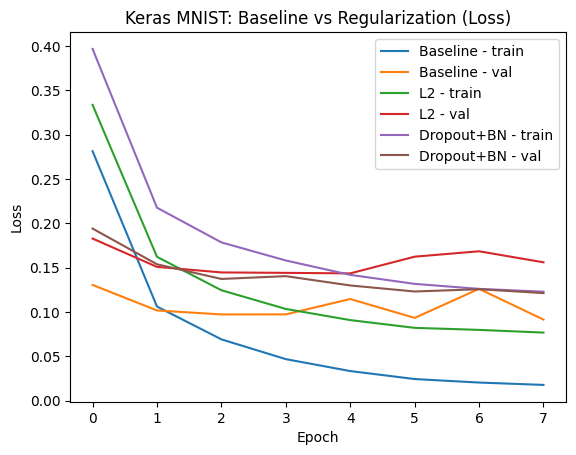

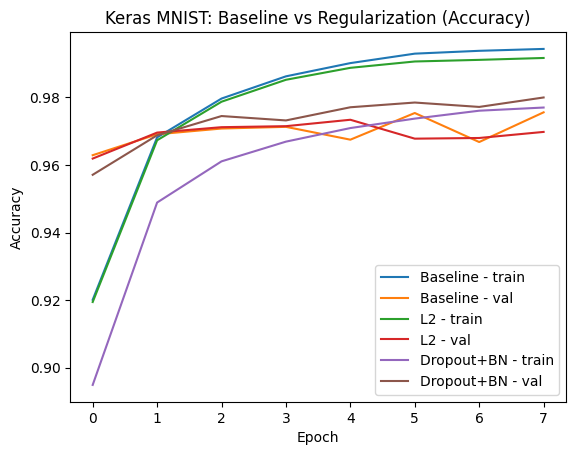

In [5]:
EPOCHS = 8
BATCH_SIZE = 128

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Baseline
baseline = build_baseline_mlp()
baseline.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=loss_fn,
    metrics=['accuracy']
)

# L2 penalty (classic)
l2_model = build_l2_mlp(l2_strength=1e-4)
l2_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=loss_fn,
    metrics=['accuracy']
)

# Dropout + BN (+ small L2)
drop_bn = build_dropout_bn_mlp(dropout_p=0.3, l2_strength=1e-4)
drop_bn.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-4),
    loss=loss_fn,
    metrics=['accuracy']
)

histories = {}
histories['Baseline'] = baseline.fit(
    x_tr, y_tr,
    validation_data=(x_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=2
)

histories['L2'] = l2_model.fit(
    x_tr, y_tr,
    validation_data=(x_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=2
)

histories['Dropout+BN'] = drop_bn.fit(
    x_tr, y_tr,
    validation_data=(x_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=2
)

plot_history(histories, title='Keras MNIST: Baseline vs Regularization')


In [6]:
# Evaluate on test set
def eval_model(model, name):
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    print(f"{name:12s} | test loss: {test_loss:.4f} | test acc: {test_acc:.4f}")

eval_model(baseline, 'Baseline')
eval_model(l2_model,  'L2')
eval_model(drop_bn,   'Dropout+BN')


Baseline     | test loss: 0.0960 | test acc: 0.9751
L2           | test loss: 0.1636 | test acc: 0.9698
Dropout+BN   | test loss: 0.1169 | test acc: 0.9799


---
## Part B — PyTorch (MNIST)

> This section mirrors the same idea with a simple training loop.

**Tip:** If you're demoing in class, you can skip Part B and only run Part A.

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

print('PyTorch:', torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


PyTorch: 2.9.0+cpu


device(type='cpu')

In [8]:
# Load MNIST via torchvision
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # flatten 28x28 -> 784
])

train_ds = datasets.MNIST(root='.', train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root='.', train=False, download=True, transform=transform)

# Optional: use a subset to keep runtime small (set to None to use full train set)
subset_n = 20000
train_idx = list(range(subset_n))
train_ds_small = Subset(train_ds, train_idx)

train_loader = DataLoader(train_ds_small, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=256, shuffle=False)


100%|██████████| 9.91M/9.91M [00:00<00:00, 22.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 619kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 5.69MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.88MB/s]


In [9]:
class TorchMLP(nn.Module):
    def __init__(self, use_dropout=False, p=0.3, use_bn=False):
        super().__init__()
        layers = []
        layers.append(nn.Linear(784, 256, bias=not use_bn))
        if use_bn:
            layers.append(nn.BatchNorm1d(256))
        layers.append(nn.ReLU())
        if use_dropout:
            layers.append(nn.Dropout(p=p))

        layers.append(nn.Linear(256, 256, bias=not use_bn))
        if use_bn:
            layers.append(nn.BatchNorm1d(256))
        layers.append(nn.ReLU())
        if use_dropout:
            layers.append(nn.Dropout(p=p))

        layers.append(nn.Linear(256, 10))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


In [10]:
def accuracy_from_logits(logits, y):
    preds = logits.argmax(dim=1)
    return (preds == y).float().mean().item()

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, total_acc, n = 0.0, 0.0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        bs = x.size(0)
        total_loss += loss.item() * bs
        total_acc += accuracy_from_logits(logits, y) * bs
        n += bs
    return total_loss / n, total_acc / n

@torch.no_grad()
def eval_epoch(model, loader, criterion):
    model.eval()
    total_loss, total_acc, n = 0.0, 0.0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        bs = x.size(0)
        total_loss += loss.item() * bs
        total_acc += accuracy_from_logits(logits, y) * bs
        n += bs
    return total_loss / n, total_acc / n


In [11]:
def run_training(name, model, optimizer, epochs=6):
    criterion = nn.CrossEntropyLoss()
    model = model.to(device)
    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}
    for ep in range(epochs):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion)
        te_loss, te_acc = eval_epoch(model, test_loader, criterion)
        history['train_loss'].append(tr_loss)
        history['train_acc'].append(tr_acc)
        history['test_loss'].append(te_loss)
        history['test_acc'].append(te_acc)
        print(f"{name} | epoch {ep+1}/{epochs} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | test loss {te_loss:.4f} acc {te_acc:.4f}")
    return history

def plot_torch_histories(histories, title):
    plt.figure()
    for name, h in histories.items():
        plt.plot(h['train_loss'], label=f"{name} - train")
        plt.plot(h['test_loss'], label=f"{name} - test")
    plt.title(f"{title} (Loss)")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure()
    for name, h in histories.items():
        plt.plot(h['train_acc'], label=f"{name} - train")
        plt.plot(h['test_acc'], label=f"{name} - test")
    plt.title(f"{title} (Accuracy)")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


### B1) Train baseline vs weight decay vs dropout+BN and plot

Baseline | epoch 1/6 | train loss 0.5515 acc 0.8547 | test loss 0.2749 acc 0.9193
Baseline | epoch 2/6 | train loss 0.2162 acc 0.9375 | test loss 0.1942 acc 0.9418
Baseline | epoch 3/6 | train loss 0.1495 acc 0.9559 | test loss 0.1648 acc 0.9508
Baseline | epoch 4/6 | train loss 0.1054 acc 0.9685 | test loss 0.1327 acc 0.9597
Baseline | epoch 5/6 | train loss 0.0782 acc 0.9769 | test loss 0.1208 acc 0.9626
Baseline | epoch 6/6 | train loss 0.0581 acc 0.9825 | test loss 0.1162 acc 0.9657
WeightDecay | epoch 1/6 | train loss 0.5600 acc 0.8483 | test loss 0.2675 acc 0.9182
WeightDecay | epoch 2/6 | train loss 0.2125 acc 0.9391 | test loss 0.1805 acc 0.9474
WeightDecay | epoch 3/6 | train loss 0.1413 acc 0.9599 | test loss 0.1684 acc 0.9492
WeightDecay | epoch 4/6 | train loss 0.1067 acc 0.9680 | test loss 0.1302 acc 0.9599
WeightDecay | epoch 5/6 | train loss 0.0795 acc 0.9754 | test loss 0.1283 acc 0.9622
WeightDecay | epoch 6/6 | train loss 0.0579 acc 0.9829 | test loss 0.1179 acc 0.964

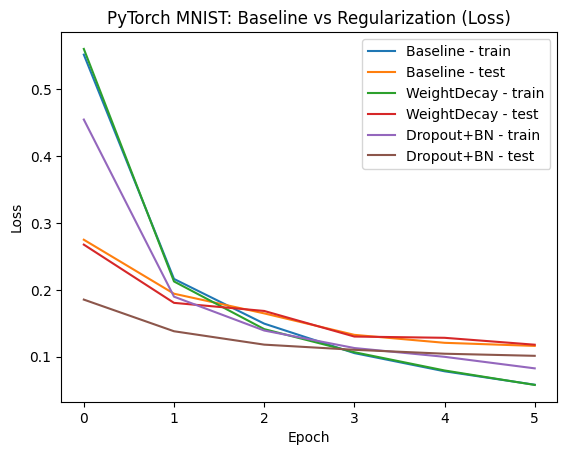

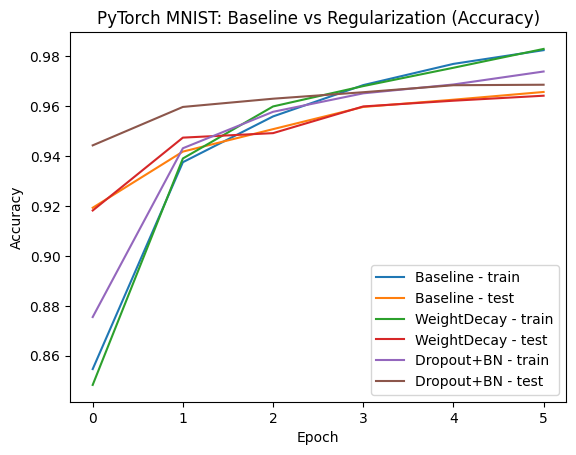

In [12]:
EPOCHS_TORCH = 6

# Baseline
torch_baseline = TorchMLP(use_dropout=False, use_bn=False)
opt_base = optim.Adam(torch_baseline.parameters(), lr=1e-3)

# Weight decay (L2) via optimizer
torch_wd = TorchMLP(use_dropout=False, use_bn=False)
opt_wd = optim.AdamW(torch_wd.parameters(), lr=1e-3, weight_decay=1e-4)

# Dropout + BN (and weight decay)
torch_drop_bn = TorchMLP(use_dropout=True, p=0.3, use_bn=True)
opt_drop_bn = optim.AdamW(torch_drop_bn.parameters(), lr=1e-3, weight_decay=1e-4)

torch_histories = {}
torch_histories['Baseline'] = run_training('Baseline', torch_baseline, opt_base, epochs=EPOCHS_TORCH)
torch_histories['WeightDecay'] = run_training('WeightDecay', torch_wd, opt_wd, epochs=EPOCHS_TORCH)
torch_histories['Dropout+BN'] = run_training('Dropout+BN', torch_drop_bn, opt_drop_bn, epochs=EPOCHS_TORCH)

plot_torch_histories(torch_histories, title='PyTorch MNIST: Baseline vs Regularization')


## Notes

- The **baseline** typically achieves very high **training** accuracy quickly.
- With more epochs, the baseline may show a bigger **train–val gap** (overfitting).
- **Regularization** (weight decay / dropout / BN) generally reduces that gap and improves generalization.

**To make the effect more obvious:**
- Increase epochs (e.g., 15–30)
- Increase model width (e.g., 512–1024)
- Reduce training data size (e.g., subset_n = 5000)
